### Dynamics

Via chain rule of $\mathbf{GP}_i \equiv \{T_{S,i}\ |\ t,\ Q_1,\ Q_2\}$, where $t \equiv$ time elapsed since initial conditions,

$$\tag{1} \dot{T}_{S,i} \approx \dot{\mathbf{GP}}_i = \frac{\partial \mathbf{GP}_i}{\partial t} + \left(\frac{\partial \mathbf{GP}_i}{\partial Q_1}\right) \dot{Q}_1 + \left(\frac{\partial \mathbf{GP}_i}{\partial Q_2}\right) \dot{Q}_2$$

In [9]:
import os
dir = os.path.abspath('')  # directory of notebook
import pandas as pd
import numpy as np
from FoKL import FoKLRoutines
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

In [52]:
filename = "tclab_sine_test.csv"
data = pd.read_csv(os.path.join(dir, filename))

Q1 = data["Q1"].values
Q2 = data["Q2"].values
TS1 = data["T1"].values
TS2 = data["T2"].values
tvec = data["Time"].values

TS = [TS1, TS2]

Q1f = lambda t: 50 * np.sin(30 * np.pi * t / tvec[-1]) + 50  # analytic expression of heater power
Q2f = lambda t: 0
Qf = [Q1f, Q2f]
dQ1f = lambda t: 1500 * np.sin(30 * np.pi * t / tvec[-1]) * np.pi / tvec[-1]
dQ2f = lambda t: 0
dQf = [dQ1f, dQ2f]

In [4]:
GP = []
pred_TS = []
for i in range(2):
    print(f"Training TS{i + 1}:")
    GP.append(FoKLRoutines.FoKL(kernel=1, UserWarnings=False))
    # GP[i].fit([tvec, Q1, Q2], TS[i], clean=True)
    GP[i].fit([tvec, Q1], TS[i], clean=True)
    print("Done!\n")

Training TS1:
[1, 3592.127247512837]
[2, 3587.245251431803]
[2, 2325.6195698812176]
[3, 2307.576809156444]
[3, 574.1060402705099]
[4, 574.1060402705099]
[4, 540.9138514384176]
[4, -331.62357408654935]
[5, -331.62357408654935]
[5, -331.62357408654935]
[5, -384.5296810595524]
[6, -384.5296810595524]
[6, -384.5296810595524]
[6, -391.2268172424733]
[6, -394.6888620369673]
[7, -394.6888620369673]
[7, -394.6888620369673]
[7, -390.73500263956225]
Done!

Training TS2:
[1, 887.9917356918709]
[2, 887.9917356918709]
[2, -1439.7323385474297]
[3, -1439.7323385474297]
[3, -1540.4687108303328]
[4, -1540.4687108303328]
[4, -1540.8472909073566]
[4, -1801.9396256154641]
[5, -1794.1852527296953]
[5, -1795.8938302170052]
[5, -1968.8598562832037]
[6, -1968.8598562832037]
[6, -1968.8598562832037]
[6, -2004.5897332978477]
[6, -2097.395658894956]
[7, -2097.395658894956]
[7, -2094.549589461081]
[7, -2093.4442370951447]
Done!



In [5]:
pred_TS = []
for i in range(2):
    # pred_TS.append(GP[i].evaluate([tvec, Q1f(tvec), Q2f(tvec)], clean=True))
    pred_TS.append(GP[i].evaluate([tvec, Q1f(tvec)], clean=True))

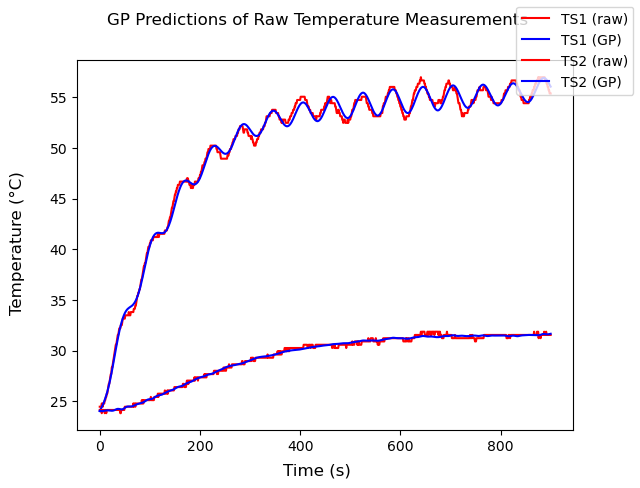

In [6]:
fig, ax = plt.subplots()
for i in range(2):
    ax.plot(tvec, TS[i], color='r')
    ax.plot(tvec, pred_TS[i], color='b')
fig.suptitle('GP Predictions of Raw Temperature Measurements')
fig.supxlabel('Time (s)')
fig.supylabel('Temperature (°C)')
_ = fig.legend(['TS1 (raw)', 'TS1 (GP)', 'TS2 (raw)', 'TS2 (GP)'])

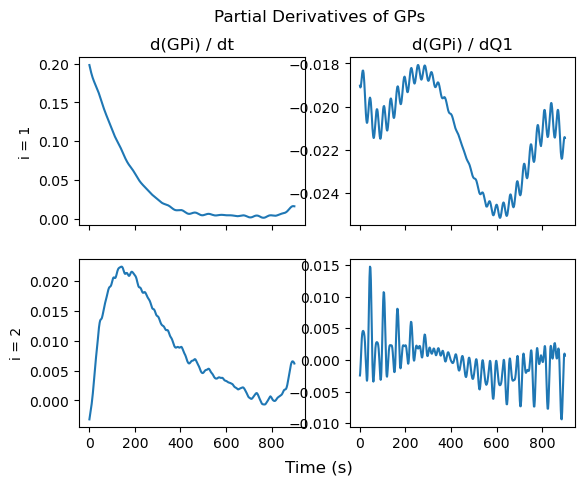

In [22]:
dGP = []
# fig, axs = plt.subplots(2, 3, sharex=True)
fig, axs = plt.subplots(2, 2, sharex=True)
for i in range(2):
    dGP.append(GP[i].bss_derivatives())
    # for j in range(3):
    for j in range(2):
        axs[i, j].plot(tvec, dGP[i][:, j])
    axs[i, 0].set_ylabel(f"i = {i + 1}")
axs[0, 0].set_title('d(GPi) / dt')
axs[0, 1].set_title('d(GPi) / dQ1')
# axs[0, 2].set_title('d(GPi) / dQ2')
fig.suptitle('Partial Derivatives of GPs')
_ = fig.supxlabel('Time (s)')

In [23]:
dGPf = []  # interpolated BSS derivatives
dTS = []  # chain rule
for i in range(2):
    dGPf.append([])
    # for j in range(3):
    for j in range(2):
        dGPf[i].append(interp1d(tvec, dGP[i][:, j]))
    
    # dTS.append(lambda t: dGPf[i][0](t) + dGPf[i][1](t) * dQ1f(t) + dGPf[i][2](t) * dQ2f(t))
    dTS.append(lambda t: dGPf[i][0](t) + dGPf[i][1](t) * dQ1f(t))

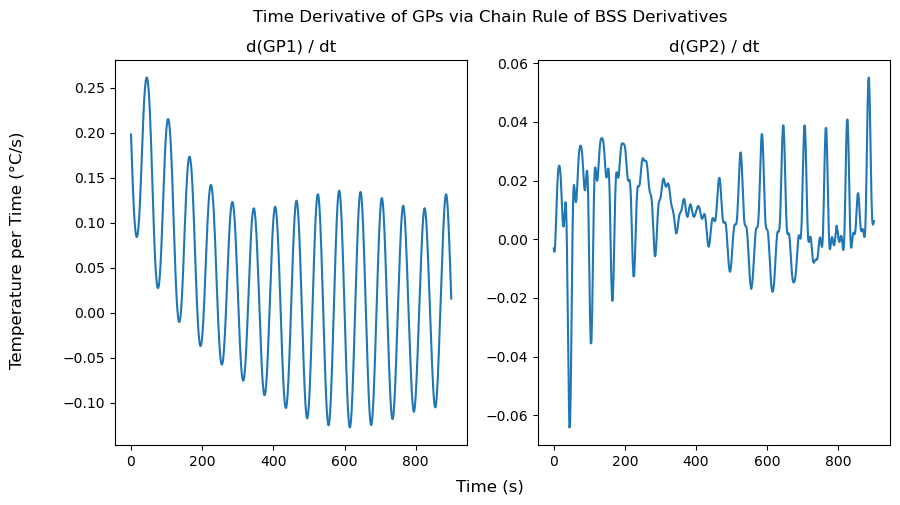

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    axs[i].plot(tvec, dTS[i](tvec))
    axs[i].set_title(f"d(GP{i + 1}) / dt")
fig.suptitle('Time Derivative of GPs via Chain Rule of BSS Derivatives')
fig.supxlabel('Time (s)')
_ = fig.supylabel('Temperature per Time (°C/s)')

In [33]:
GP_dT = []
for i in range(2):
    print(f"Training dTS{i + 1}:")
    GP_dT.append(FoKLRoutines.FoKL(kernel=1, UserWarnings=False))
    # GP_dT[i].fit([TS[i], Q1, Q2], dTS[i](tvec), clean=True)
    GP_dT[i].fit([TS[i], Q1], dTS[i](tvec), clean=True)
    print("Done!\n")

Training dTS1:
[1, -7301.167035231262]
[2, -7398.685741991832]
[2, -7426.4718824615775]
[3, -7609.731952597299]
[3, -7632.311768839469]
[4, -7628.676225733468]
[4, -7778.725848364244]
[4, -7966.162366022976]
[5, -7960.648093410488]
[5, -7953.961089965828]
[5, -8091.771464345278]
[6, -8091.771464345278]
[6, -8091.771464345278]
[6, -8126.532701329737]
[6, -8143.442182428115]
[7, -8143.442182428115]
[7, -8147.494651639]
[7, -8245.428200365528]
[7, -8240.87121258173]
[8, -8240.87121258173]
[8, -8240.87121258173]
Done!

Training dTS2:
[1, -6598.283063750362]
[2, -7265.489693828269]
[2, -7389.749985482419]
[3, -7692.081037349617]
[3, -7828.367582515323]
[4, -7860.146652094402]
[4, -8474.52336714442]
[4, -8468.258838605741]
[5, -8487.813809620919]
[5, -8709.443638187984]
[5, -8715.289971037964]
[6, -8715.289971037964]
[6, -8715.35570264894]
[6, -8746.652510067672]
[6, -8743.388781694035]
[7, -8741.865328835418]
[7, -8740.666257146057]
Done!



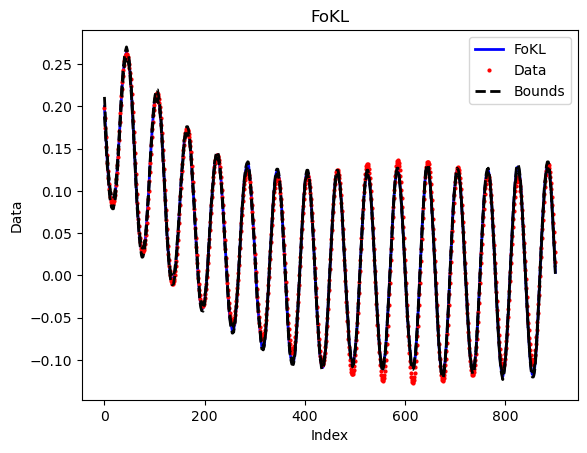

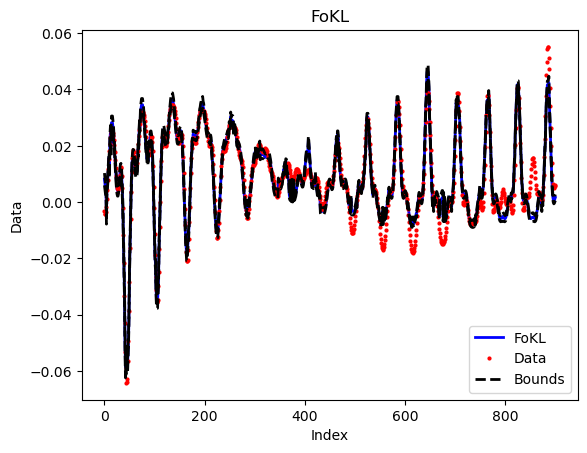

In [34]:
for i in range(2):
    GP_dT[i].coverage3(plot=True)

Using $\mathbf{GP}_T$ to model the raw data, smoothing was implicitly applied. Then, the chain rule of BSS derivatives was used to obtain accurate derivatives of the smoothed data. Modeling these derivatives as $\mathbf{GP}_{\Delta T}$, the following dynamic model is defined by a GP.

$$\dot{T} = f(T, Q_1, Q_2)$$

Plugging into the two-state ODE,

In [86]:
alpha = 0.00016                                                                     # watts / (units P1 * percent U1)
P1 = 200                                                                            # P1 units
# T_amb = list(GP[i].evaluate([0, Q1f(0), Q2f(0)], clean=True)[0] for i in range(2))  # ambient temperature
T_amb = list(GP[i].evaluate([0, Q1f(0)], clean=True)[0] for i in range(2))          # ambient temperature

IC = [[T_amb[0], T_amb[0]], [T_amb[1], T_amb[1]]]   # initial condition of states [TH1, TS1]
CpH =  7.006                                        # J/degC
CpS = 0.01                                          # J/degC
Ua =  0.051                                         # W/degC
Ub =  0.001                                         # W/degC

In [56]:
def dyi(t, y, i):
    """ODE for TSi."""
    TH_, TS_ = y
    dTH_ = (Ua * (T_amb[i] - TH_) + Ub * (TS_ - TH_) + alpha * P1 * Qf[i](t)) / CpH
    # dTS_ = GP_dT[i].evaluate([TS_, Q1f(t), Q2f(t)], clean=True, SingleInstance=True)[0]
    dTS_ = GP_dT[i].evaluate([TS_, Q1f(t)], clean=True, SingleInstance=True)[0]
    return [dTH_, dTS_]

def dy1(t, y):
    """i = 0, for (TH1, TS1) ODE."""
    return dyi(t, y, 0)

def dy2(t, y):
    """i = 1, for (TH2, TS2) ODE."""
    return dyi(t, y, 1)

dy = [dy1, dy2]

In [69]:
soln = []
for i in range(1):
    soln.append(solve_ivp(dy[i], [tvec[0], tvec[-1]], IC[i], t_eval=tvec))

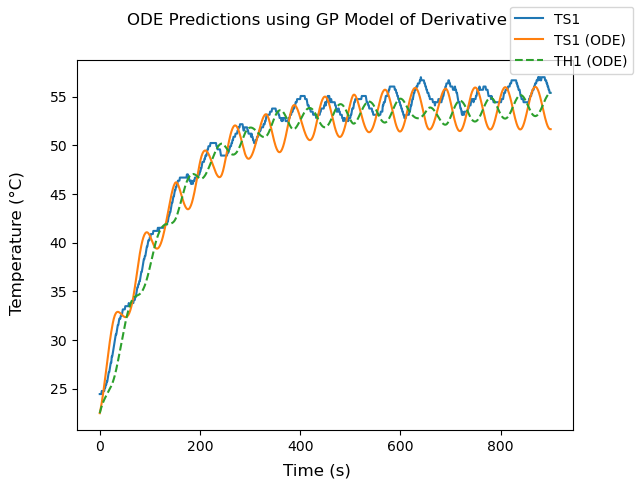

In [71]:
fig, ax = plt.subplots()
for i in range(1):
    ax.plot(tvec, TS[i], label=f"TS{i + 1}")
    ax.plot(tvec, soln[i].y[0], label=f"TS{i + 1} (ODE)")
    ax.plot(tvec, soln[i].y[1], '--', label=f"TH{i + 1} (ODE)")
fig.suptitle('ODE Predictions using GP Model of Derivative')
fig.supxlabel('Time (s)')
fig.supylabel('Temperature (°C)')
_ = fig.legend()

---

Debugging by trying two-state model with interpolated derivative (i.e., direct use of the training set of $\mathbf{GP}_{\Delta T}$ instead of the GP itself):

In [88]:
alpha = 0.00016                                                                     # watts / (units P1 * percent U1)
P1 = 200                                                                            # P1 units
T_amb = list(TS[i][0] for i in range(2))                                            # ambient temperature

IC = [[T_amb[0], T_amb[0]], [T_amb[1], T_amb[1]]]   # initial condition of states [TH1, TS1]
CpH =  7.006                                        # J/degC
CpS = 0.01                                          # J/degC
Ua =  0.051                                         # W/degC
Ub =  0.001                                         # W/degC

In [89]:
def dyi_test(t, y, i):
    """ODE for TSi using interpolated training set of GPi_dT."""
    TH_, TS_ = y
    dTH_ = (Ua * (T_amb[i] - TH_) + Ub * (TS_ - TH_) + alpha * P1 * Qf[i](t)) / CpH
    # dTS_ = GP_dT[i].evaluate([TS_, Q1f(t), Q2f(t)], clean=True, SingleInstance=True)[0]
    dTS_ = dTS[i](t)
    return [dTH_, dTS_]

def dy1_test(t, y):
    """i = 0, for (TH1, TS1) ODE."""
    return dyi_test(t, y, 0)

def dy2_test(t, y):
    """i = 1, for (TH2, TS2) ODE."""
    return dyi_test(t, y, 1)

dy_test = [dy1_test, dy2_test]

In [92]:
soln = []
for i in range(2):
    soln.append(solve_ivp(dy_test[i], [tvec[0], tvec[-1]], IC[i], t_eval=tvec))

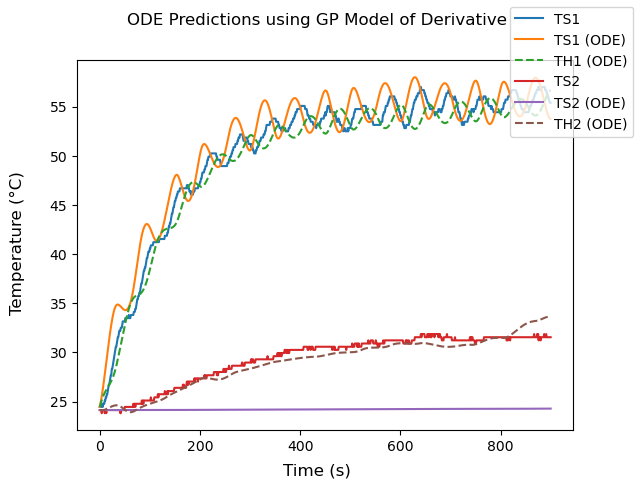

In [93]:
fig, ax = plt.subplots()
for i in range(2):
    ax.plot(tvec, TS[i], label=f"TS{i + 1}")
    ax.plot(tvec, soln[i].y[0], label=f"TS{i + 1} (ODE)")
    ax.plot(tvec, soln[i].y[1], '--', label=f"TH{i + 1} (ODE)")
fig.suptitle('ODE Predictions using GP Model of Derivative')
fig.supxlabel('Time (s)')
fig.supylabel('Temperature (°C)')
_ = fig.legend()